# Prototypical implementation of an extended SIER model by Gomes et al.

This focuses on the susceptibility model for now.

By @maestro_rayo

Based on:

https://www.medrxiv.org/content/10.1101/2020.07.23.20160762v2.full.pdf

And its MATLAB implementation in:

https://github.com/mgmgomes1/covid

In [24]:
#Main parameters
pop = pow(10,3)
cv = 2
R_0 = 3
ga = 1./4 
delta = 1./4

#Use normal or gamma distribution for susceptibility
susc_dist = "gamma" #"gamma" or "normal"


First we build distribution of population by susceptibility

First moment 1.0641575057822201
Mean : 1.0
CV : 2.0


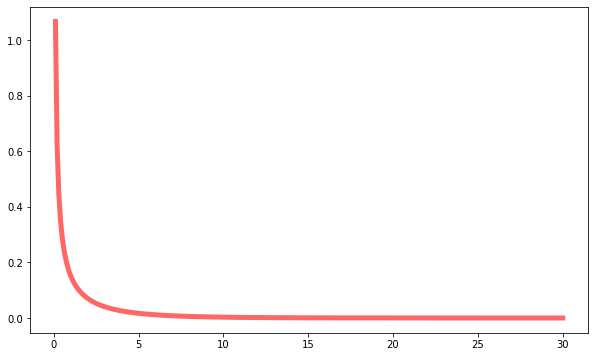

In [29]:
from scipy.stats import  norm, gamma
from math import isclose,sqrt
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

#Susceptibility range, here using the same as in MATLAB imp. by Gomes et al.
N = 30
step = 0.1
#Number of buckets (susceptibility degrees)
B = int(N/step)

if susc_dist == 'gamma': 
    x = np.linspace(0,N,num=B)
    var = pow(cv,2)
    k = 1/var
    n = gamma(k,0,var)
else: #normal
    x = np.linspace(-N//2,1+N//2,num=B)
    #Mean=1 and stdev = cv
    n = norm(1, cv)

#Plot dist
ax.plot(x,n.pdf(x) ,'r-', lw=5, alpha=0.6, label='norm pdf')

#Compute percentage per bucket
dist = [n.cdf(x[0])]
for i in range(1,len(x)):
    dist.append(n.cdf(x[i])-n.cdf((x[i-1])))
dist[-1] = 1 - sum(dist[:-1])
    
dist = np.array(dist)

#This should be close to 1
assert isclose(sum(dist),1,abs_tol=1e-3)

#Distribute population in buckets
pop_dist = pop*dist 

#This should be close to pop
assert isclose(sum(pop_dist),pop,abs_tol=1e-3)


#In case dist. is normal, we shift to positive axis
x = np.linspace(0,N,num=B)
#First moment
k1 = np.dot(dist,x)
print('First moment',k1)

#Check mean of distribution ~ 1
import scipy.integrate as integrate
print('Mean :',n.mean())

#Check this is ~ to cv
print('CV :',sqrt(n.var()))

Final susceptible  603
Final infected then recovered  397


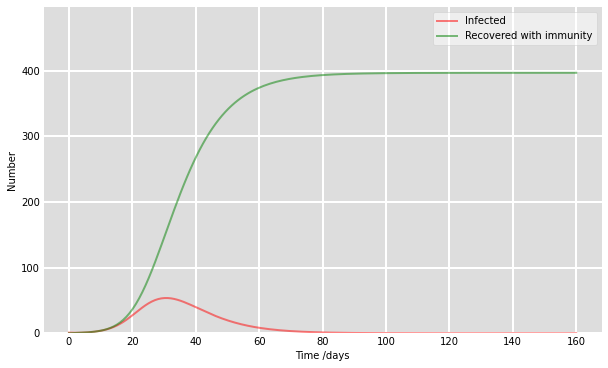

In [31]:
#Based on https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/

from scipy.integrate import odeint

# A grid of time points (in days)
t = np.linspace(0, 160, 160)


beta = R_0/(0.5/delta +1/ga)/k1

# The extended SIER model differential equations.
def deriv(y, t, N, delta, beta, ga):
    sus = np.linspace(0,N,num=B)
    
    S = y[:B]
    I = y[B:2*B]
    E = y[2*B:3*B]
    R= y[3*B:4*B]
    
    lam = (beta/pop)*sum(I+0.5*E)
    dSdt = -lam *sus* S 
    dEdt = lam *sus* S - delta*E
    dIdt = delta*E - ga*I
    dRdt = ga * I
    

    return np.concatenate(( dSdt,dIdt, dEdt,dRdt),axis=0)

#Initial conditions
inf = 1

S = pop_dist - inf*dist
I = inf*dist
E =  np.array(B*[0])
R =  np.array(B*[0])

# Initial conditions vector
y0 = np.concatenate(( S,I, E,R),axis=0)

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N,delta, beta, ga))
ret = ret.T

#Succeptible 
S = [] 
for j in range(160):
    temp=0
    for i in range(B):
        temp += ret[i][j]
    S.append(temp)

print('Final susceptible ',round(S[-1]))

#Infected
I = []
for j in range(160):
    temp=0
    for i in range(B):
        temp += ret[B+i][j]
    I.append(temp)

#Exposed 
E = []
for j in range(160):
    temp=0
    for i in range(B):
        temp += ret[2*B+i][j]
    E.append(temp)


#Recovered 
R = []
for j in range(160):
    temp=0
    for i in range(B):
        temp += ret[3*B+i][j]
    R.append(temp)
print('Final infected then recovered ', round(R[-1]))


#Reff calculation

RE= []
for j in range(160):
    lam = (beta/pop)*(I[j]+0.5*E[j])
    D = (I[j]+0.5*E[j])/(0.5/delta + 1/ga)
    Reff = lam/D*np.dot(np.linspace(0,N,num=B),[ret[i][j] for i in range(B) ] )
    RE.append(Reff)

    

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.set_ylim(0,R[-1]+100)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.rcParams["figure.figsize"] = (10,6)
plt.show()

In [27]:
#HIT
index = min([ i for i in range(len(RE)) if RE[i] <= 1 ])
print('HIT', round( (R[index]+I[index])/pop*100,2) , '%' )

HIT 17.35 %


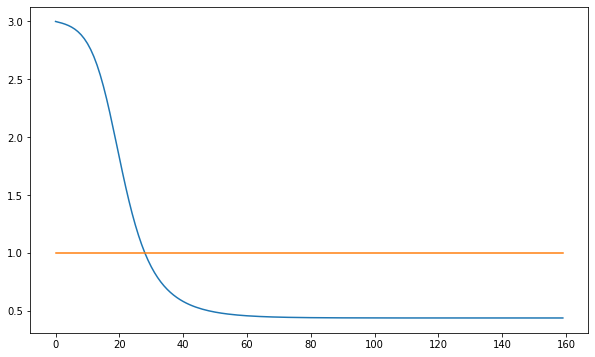

In [28]:
#Plot Reff
plt.plot(RE)
plt.plot([1 for i in range(160)])